In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/non_alcoholic/spectrogram_F3_non_alc_test4.png
/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/non_alcoholic/spectrogram_Fz_non_alc_test70.png
/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/non_alcoholic/spectrogram_Cz_non_alc_test21.png
/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/non_alcoholic/spectrogram_F4_non_alc_test147.png
/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/non_alcoholic/spectrogram_AF2_non_alc_test137.png
/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/non_alcoholic/spectrogram_Cz_non_alc_test12.png
/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/non_alcoholic/spectrogram_F3_non_alc_test130.png
/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/non_alcoholic/spectrogram_Fz_non_alc_test56.png
/kaggle/input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test/n

**Improt Library**

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**Data Loading**

In [4]:
# Define directories for Kaggle
train_folder = '../input/eeg-spectrogram-images/Alcohol Data (12 channel)/Train'
test_folder = '../input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test'

In [5]:
import os

def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.png'):
                count += 1
    return count

# Define directories for Kaggle
train_folder = '../input/eeg-spectrogram-images/Alcohol Data (12 channel)/Train'
test_folder = '../input/eeg-spectrogram-images/Alcohol Data (12 channel)/Test'

# Count images in each folder
train_image_count = count_images_in_folder(train_folder)
test_image_count = count_images_in_folder(test_folder)

# Print results
print(f"Number of images in train folder: {train_image_count}")
print(f"Number of images in test folder: {test_image_count}")

# If you want to count images in subfolders (alcoholic and non_alcoholic), you can do this:
def count_images_in_subfolders(folder_path):
    counts = {}
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            counts[subfolder] = count_images_in_folder(subfolder_path)
    return counts

# Count images in subfolders
train_subfolder_counts = count_images_in_subfolders(train_folder)
test_subfolder_counts = count_images_in_subfolders(test_folder)

# Print results for subfolders
print("Number of images in train subfolders:")
for subfolder, count in train_subfolder_counts.items():
    print(f"  {subfolder}: {count}")

print("Number of images in test subfolders:")
for subfolder, count in test_subfolder_counts.items():
    print(f"  {subfolder}: {count}")


Number of images in train folder: 5750
Number of images in test folder: 1450
Number of images in train subfolders:
  non_alcoholic: 2875
  alcoholic: 2875
Number of images in test subfolders:
  non_alcoholic: 725
  alcoholic: 725


**Scaling & Labeling**

In [6]:
def load_and_preprocess_images(folder, label):
    images = []
    labels = []

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = image.load_img(img_path, target_size=(128, 128), color_mode='rgb')  # Resize to 128x128
        img_array = image.img_to_array(img) / 255.0  # Convert to array and normalize

        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels)



In [7]:

# Load and preprocess images for training data
train_images_alcoholic, train_labels_alcoholic = load_and_preprocess_images(os.path.join(train_folder, 'alcoholic'), label=1)
train_images_non_alcoholic, train_labels_non_alcoholic = load_and_preprocess_images(os.path.join(train_folder, 'non_alcoholic'), label=0)

# Load and preprocess images for testing data
test_images_alcoholic, test_labels_alcoholic = load_and_preprocess_images(os.path.join(test_folder, 'alcoholic'), label=1)
test_images_non_alcoholic, test_labels_non_alcoholic = load_and_preprocess_images(os.path.join(test_folder, 'non_alcoholic'), label=0)

# Combine and shuffle training data
train_images = np.concatenate([train_images_alcoholic, train_images_non_alcoholic], axis=0)
train_labels = np.concatenate([train_labels_alcoholic, train_labels_non_alcoholic], axis=0)

# Combine and shuffle testing data
test_images = np.concatenate([test_images_alcoholic, test_images_non_alcoholic], axis=0)
test_labels = np.concatenate([test_labels_alcoholic, test_labels_non_alcoholic], axis=0)

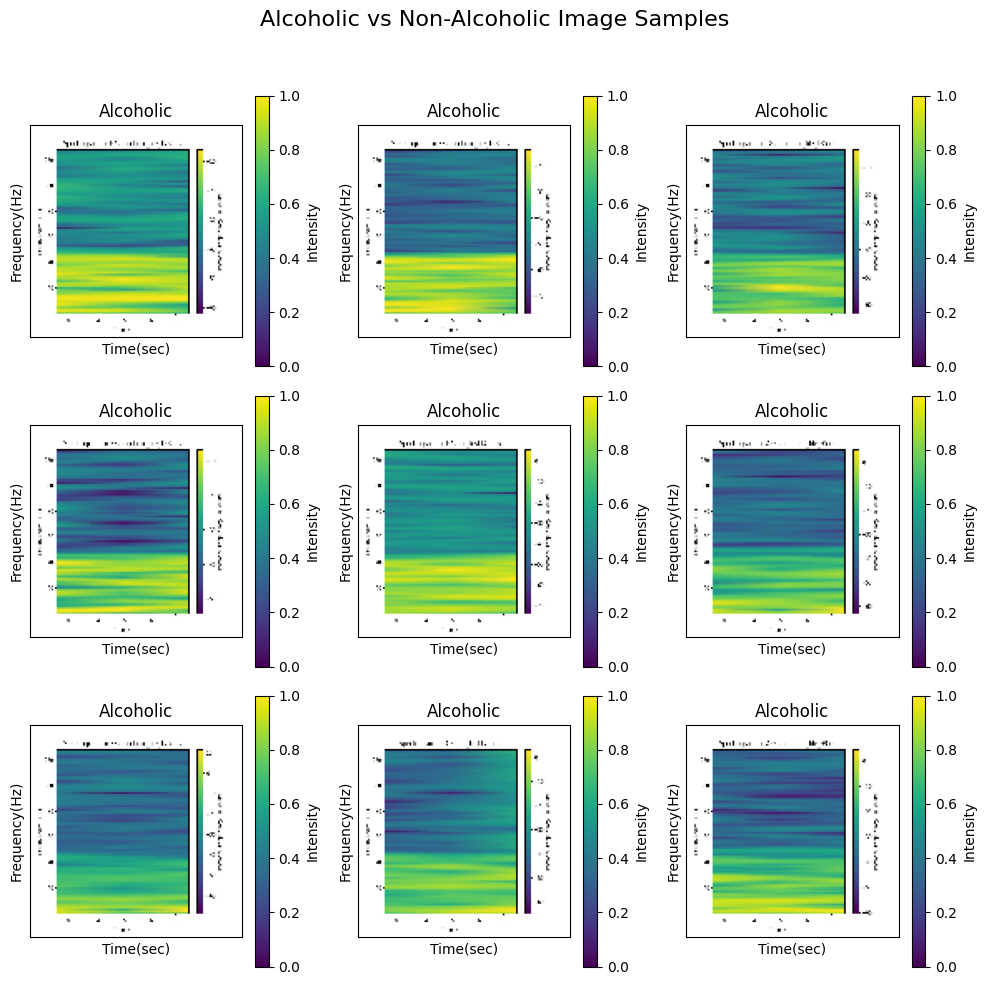

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Plot some of the images
plt.figure(figsize=(10, 10))

# Determine the number of images to display
num_images_to_display = 9

# Normalize images for proper display if they aren't already in the correct range
for i in range(num_images_to_display):
    plt.subplot(3, 3, i + 1)

    # Ensure the color bar will fit
    plt.xticks([])  # Remove x ticks
    plt.yticks([])  # Remove y ticks
    plt.grid(False)  # Remove grid

    # Display alcoholic images first
    if i < len(train_images_alcoholic):
        img = train_images_alcoholic[i]
        title = 'Alcoholic'
    else:
        img = train_images_non_alcoholic[i - len(train_images_alcoholic)]
        title = 'Non-alcoholic'

    # Normalize image if not already in [0, 1]
    if img.max() > 1:
        img = img / 255.0

    # Plot image and add colorbar
    im = plt.imshow(img, cmap='viridis')  # Added colormap 'viridis' for intensity visualization
    plt.title(title)

    # Add labels and colorbar
    plt.xlabel('Time(sec)')
    plt.ylabel('Frequency(Hz)')
    cbar = plt.colorbar(im)  # Add colorbar
    cbar.set_label('Intensity')

# Add a title for the entire figure
plt.suptitle('Alcoholic vs Non-Alcoholic Image Samples', fontsize=16)

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap with the title
plt.show()


**EDA**

In [9]:
 # Split data into training and validation sets
 train_images, val_images, train_labels, val_labels = train_test_split(
     train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42
 )

In [10]:
 # Check the number of images in the validation set
 num_val_images = len(val_images)

 print(f"Number of images in the validation set: {num_val_images}")

Number of images in the validation set: 1150


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preparation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

# Convert to tf.data.Dataset and repeat
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).repeat()

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).repeat()


**Compile and train the model**

In [12]:
cnn_model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3, 3), activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(512, (3, 3), activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dropout(0.4)  # Additional dropout to reduce overfitting
])

# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [13]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             

 Total params: 1,572,544 (6.00 MB)

 Trainable params: 1,570,560 (5.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [14]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
import tensorflow as tf

# K-Fold Cross-Validation with 7 folds
kf = KFold(n_splits=7, shuffle=True, random_state=42)

# Lists to store metrics
svm_train_accuracies = []
svm_val_accuracies = []
svm_train_losses = []
svm_val_losses = []


In [15]:
for train_index, val_index in kf.split(train_images):
    fold_train_images, fold_val_images = train_images[train_index], train_images[val_index]
    fold_train_labels, fold_val_labels = train_labels[train_index], train_labels[val_index]

    # Extract features using the CNN model
    fold_train_features = cnn_model.predict(fold_train_images, verbose=1)
    fold_val_features = cnn_model.predict(fold_val_images, verbose=1)

    # SVM training with regularization (tuned C parameter)
    svm_clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, C=0.1))
    svm_clf.fit(fold_train_features, fold_train_labels)

    # Training accuracy and loss
    fold_train_predictions = svm_clf.predict(fold_train_features)
    train_accuracy = accuracy_score(fold_train_labels, fold_train_predictions)
    train_loss = log_loss(fold_train_labels, svm_clf.predict_proba(fold_train_features))
    svm_train_accuracies.append(train_accuracy)
    svm_train_losses.append(train_loss)

    # Validation accuracy and loss
    fold_val_predictions = svm_clf.predict(fold_val_features)
    val_accuracy = accuracy_score(fold_val_labels, fold_val_predictions)
    val_loss = log_loss(fold_val_labels, svm_clf.predict_proba(fold_val_features))
    svm_val_accuracies.append(val_accuracy)
    svm_val_losses.append(val_loss)

    print(f"Fold Training Accuracy: {train_accuracy:.4f}, Fold Validation Accuracy: {val_accuracy:.4f}")


124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step
Fold Training Accuracy: 0.9764, Fold Validation Accuracy: 0.9149
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 253ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step
Fold Training Accuracy: 0.9782, Fold Validation Accuracy: 0.9239
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step
Fold Training Accuracy: 0.9716, Fold Validation Accuracy: 0.9391
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step
Fold Training Accuracy: 0.9718, Fold Validation Accuracy: 0.9406
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step
Fold Training Accuracy: 0.9757, Fold Validation Accuracy: 0.9376
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step
Fold Training Accuracy: 0.9734, Fold Validation Accuracy: 0.9330
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step
Fold Training A

In [16]:
# Average accuracies and losses after all folds
average_train_accuracy = np.mean(svm_train_accuracies)
average_val_accuracy = np.mean(svm_val_accuracies)
average_train_loss = np.mean(svm_train_losses)
average_val_loss = np.mean(svm_val_losses)

print(f"Average Training Accuracy: {average_train_accuracy:.4f}, Average Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Average Training Loss: {average_train_loss:.4f}, Average Validation Loss: {average_val_loss:.4f}")

Average Training Accuracy: 0.9747, Average Validation Accuracy: 0.9300
Average Training Loss: 0.1001, Average Validation Loss: 0.1873


In [17]:
# Extract features from the test dataset using the CNN model
test_features = cnn_model.predict(test_images, verbose=1)

# SVM prediction on test features
test_predictions = svm_clf.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with CNN-SVM Hybrid Model: {test_accuracy:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 271ms/step
Test Accuracy with CNN-SVM Hybrid Model: 0.8634


**Graph plot**

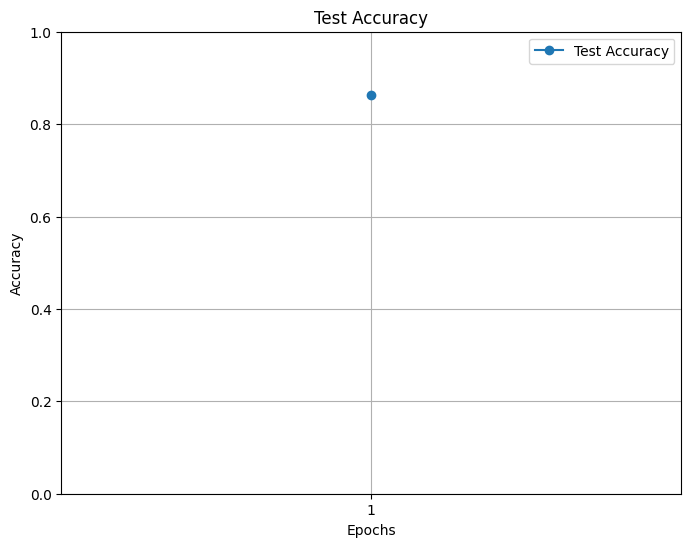

In [18]:
import matplotlib.pyplot as plt

# Assuming you have only one test accuracy value and not a history of accuracies and losses over epochs.
# If you want to plot the test accuracy across epochs, you would need historical data from multiple runs.

# Test Accuracy (single value)
test_accuracies = [test_accuracy]  # List with a single accuracy value
epochs = [1]  # List with a single epoch value

# Plot Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Note: Since this is a single value, it's more typical to plot accuracy over multiple epochs.
# If you have multiple test accuracies from different runs or epochs, you can plot them accordingly.


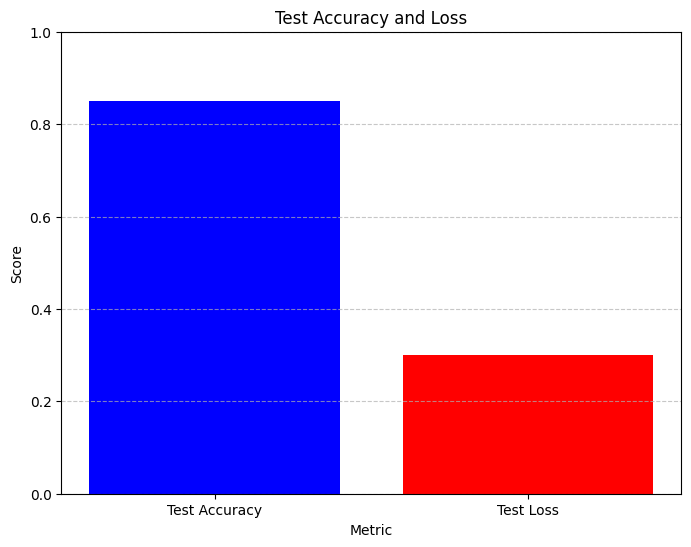

In [19]:
import matplotlib.pyplot as plt

# Assuming you have the test accuracy value and want to visualize it.
test_accuracy = 0.85  # Example value; replace with your actual test_accuracy
test_loss = 0.30      # Example value; replace with your actual test_loss

# Create a dictionary with metrics for plotting
metrics = {
    'Test Accuracy': test_accuracy,
    'Test Loss': test_loss
}

# Plot Test Accuracy and Loss
plt.figure(figsize=(8, 6))

# Bar plot for Test Accuracy and Loss
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'red'])
plt.title('Test Accuracy and Loss')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


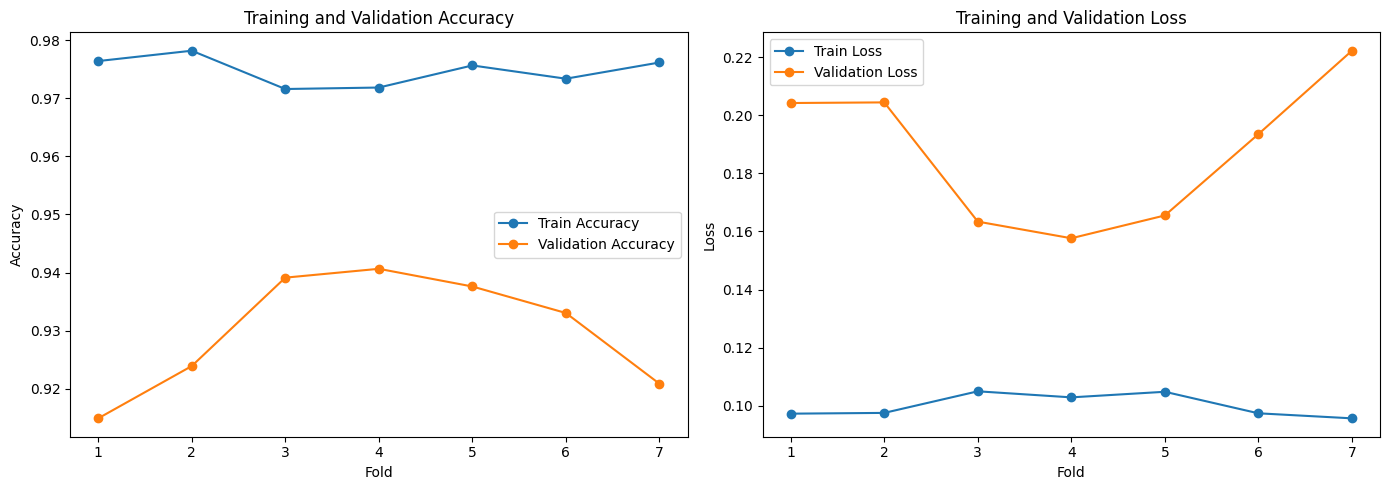

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(svm_train_accuracies) + 1), svm_train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, len(svm_val_accuracies) + 1), svm_val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(svm_train_accuracies) + 1))
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(svm_train_losses) + 1), svm_train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(svm_val_losses) + 1), svm_val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.xticks(range(1, len(svm_train_losses) + 1))
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
# Average accuracy across folds
print(f"Average Training Accuracy across folds: {np.mean(svm_train_accuracies):.4f}")
print(f"Average Validation Accuracy across folds: {np.mean(svm_val_accuracies):.4f}")


Average Training Accuracy across folds: 0.9747
Average Validation Accuracy across folds: 0.9300


**Model Evaluation**

46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step


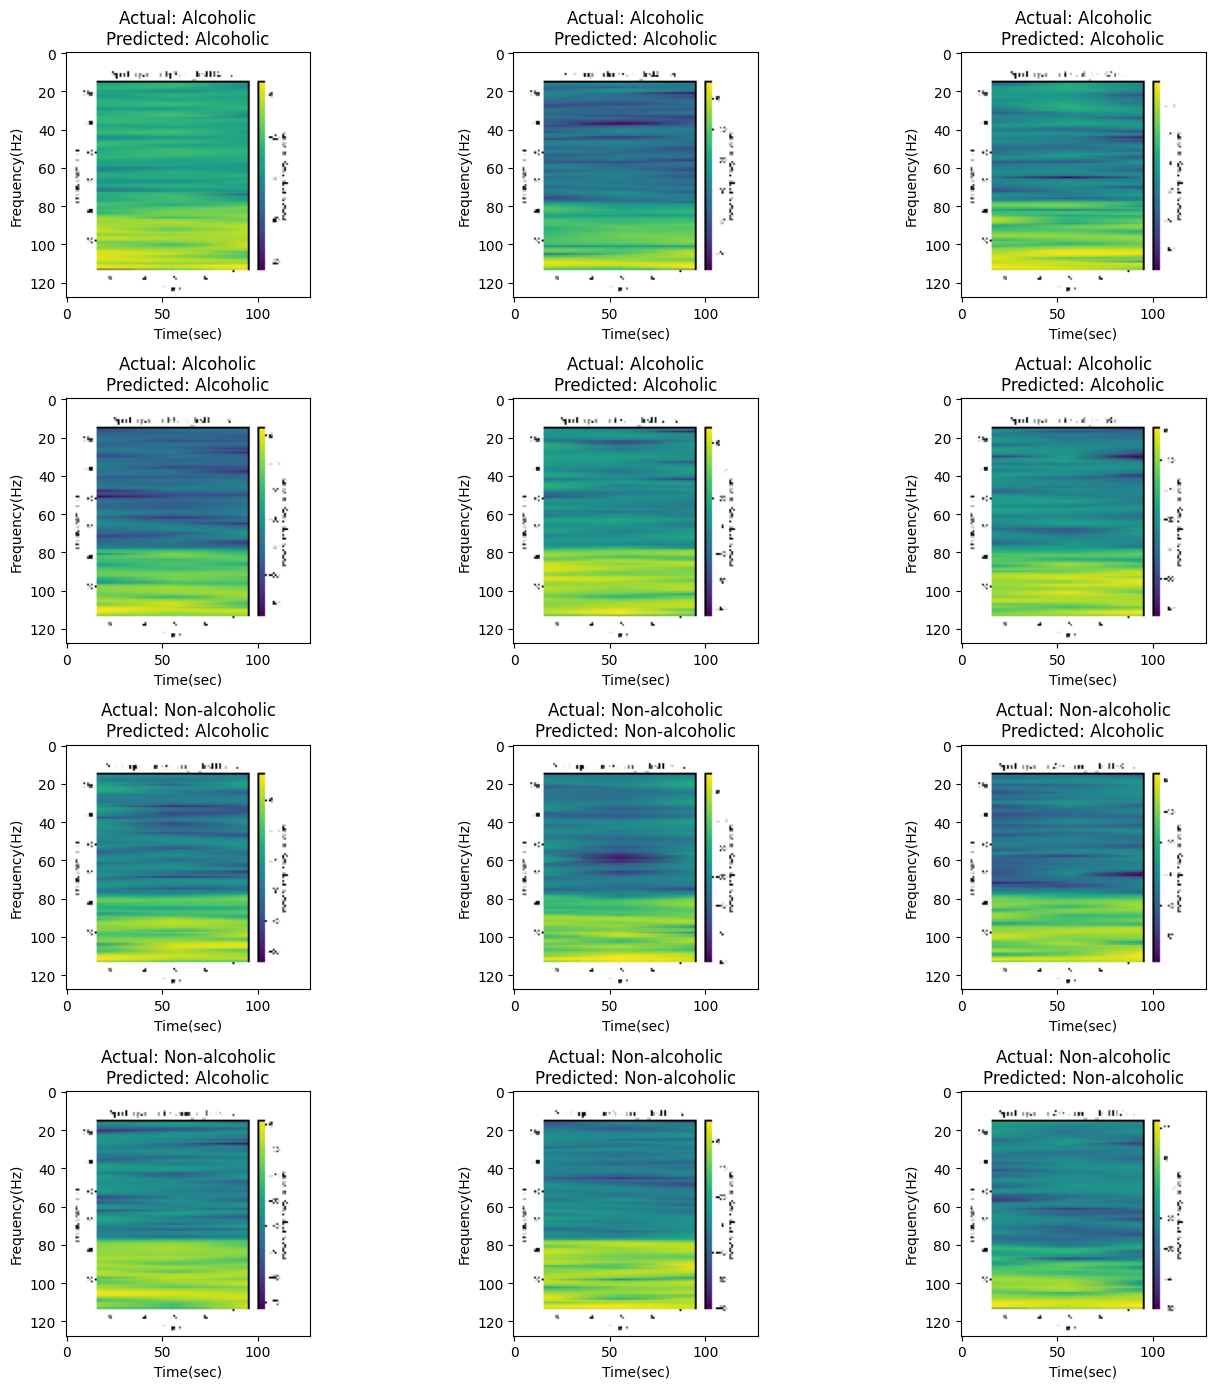

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming cnn_model is the CNN feature extractor and svm_clf is the trained SVM classifier
# Generate predictions for the test dataset using the trained SVM
test_features = cnn_model.predict(test_images, verbose=1)  # Extract features using CNN
test_predictions = svm_clf.predict(test_features)  # SVM prediction

# Extract actual labels from the test dataset
actual_labels = test_labels.flatten()

# Separate alcoholic and non-alcoholic images based on labels
alcoholic_indices = np.where(actual_labels == 1)[0]  # Indices of alcoholic samples
non_alcoholic_indices = np.where(actual_labels == 0)[0]  # Indices of non-alcoholic samples

# Define the number of samples per category (5 alcoholic, 5 non-alcoholic)
num_samples_per_category = 6

# Randomly select 5 alcoholic and 5 non-alcoholic samples
selected_alcoholic_indices = np.random.choice(alcoholic_indices, size=num_samples_per_category, replace=False)
selected_non_alcoholic_indices = np.random.choice(non_alcoholic_indices, size=num_samples_per_category, replace=False)

# Combine the selected indices
selected_indices = np.concatenate([selected_alcoholic_indices, selected_non_alcoholic_indices])

# Define a function to decode the labels
def decode_label(label):
    return 'Alcoholic' if label == 1 else 'Non-alcoholic'

# Create a DataFrame for plotting
plot_data = {
    'Image': [],
    'Actual': [],
    'Predicted': []
}

# Prepare data for plotting
for i in selected_indices:
    img = test_images[i]
    actual = decode_label(actual_labels[i])
    predicted = decode_label(test_predictions[i])

    # Convert image array to RGB (if needed)
    img_rgb = (img * 255).astype(np.uint8)
    img_rgb = np.clip(img_rgb, 0, 255)

    plot_data['Image'].append(img_rgb)
    plot_data['Actual'].append(actual)
    plot_data['Predicted'].append(predicted)

# Create a DataFrame for easier plotting
df_plot = pd.DataFrame(plot_data)

# Plotting with color bars and titles
plt.figure(figsize=(14, 14))
for i in range(12):  # 5 alcoholic + 5 non-alcoholic
    plt.subplot(4, 3, i + 1)
    plt.imshow(df_plot['Image'][i])
    plt.xlabel('Time(sec)')
    plt.ylabel('Frequency(Hz)')
    plt.title(f"Actual: {df_plot['Actual'][i]}\nPredicted: {df_plot['Predicted'][i]}")
    plt.axis('on')  # Keep the axis visible to show labels

plt.tight_layout()
plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step


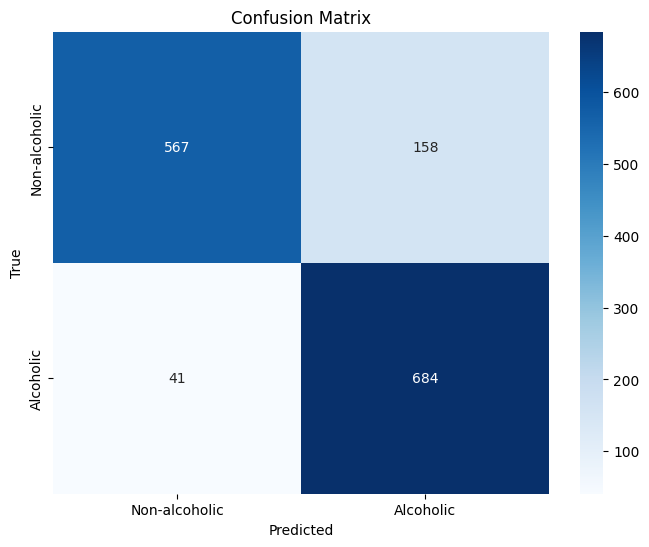

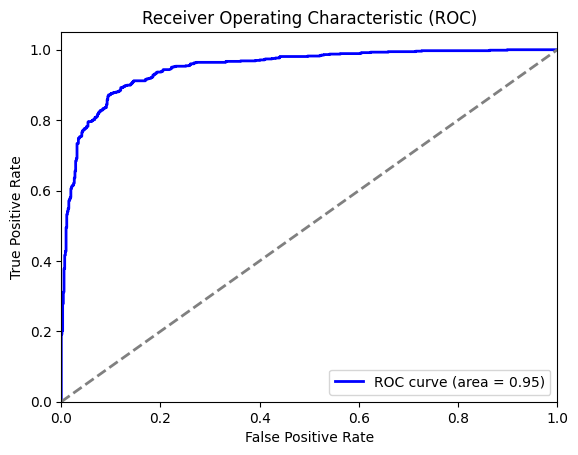

Sensitivity (Recall): 0.9434
Specificity: 0.7821
Precision: 0.8124
F1 Score: 0.8730
Accuracy: 0.8628
Balanced Accuracy: 0.8628
ROC AUC Score: 0.9491


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Extract features from the test dataset using the CNN model
test_features = cnn_model.predict(test_images, verbose=1)

# Get SVM model predictions (for ROC and confusion matrix)
predictions = svm_clf.predict_proba(test_features)[:, 1]  # Probability estimates for the positive class (Alcoholic)
y_pred = (predictions > 0.5).astype(int).flatten()  # Binary predictions (0 or 1)

# Extract true labels from the dataset
y_true = test_labels.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-alcoholic', 'Alcoholic'], yticklabels=['Non-alcoholic', 'Alcoholic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_true, predictions)
fpr, tpr, _ = roc_curve(y_true, predictions)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Sensitivity (Recall), Specificity, and Precision
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

sensitivity = TP / (TP + FN)  # Same as recall for positive class
specificity = TN / (TN + FP)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Same as sensitivity

# F1 Score
f1 = f1_score(y_true, y_pred)

# Accuracy and Balanced Accuracy
accuracy = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)

# Print all metrics
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")



Model Performance Metrics Summary:

Sensitivity (Recall): 0.9434
Specificity: 0.7821
Precision: 0.8124
F1 Score: 0.8730
Accuracy: 0.8628
Balanced Accuracy: 0.8628
ROC AUC Score: 0.9491


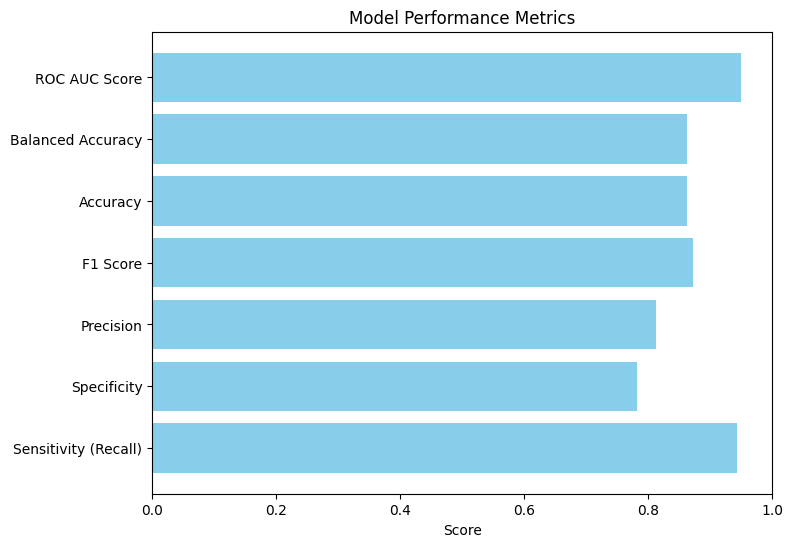

In [24]:
# Create a dictionary to store the results
metrics_summary = {
    "Sensitivity (Recall)": sensitivity,
    "Specificity": specificity,
    "Precision": precision,
    "F1 Score": f1,
    "Accuracy": accuracy,
    "Balanced Accuracy": balanced_acc,
    "ROC AUC Score": roc_auc
}

# Print all the metrics in a formatted way
print("\nModel Performance Metrics Summary:\n")
for metric, value in metrics_summary.items():
    print(f"{metric}: {value:.4f}")

# Alternatively, plot the metrics for a more visual presentation
plt.figure(figsize=(8, 6))
plt.barh(list(metrics_summary.keys()), list(metrics_summary.values()), color='skyblue')
plt.xlabel('Score')
plt.title('Model Performance Metrics')
plt.xlim(0, 1)
plt.show()


**Thank You**